# CNN-autoencoder or Denoising autoencoder to estimate color patterns

In [1]:
import os
from numpy.random import seed
seed(1)
import cv2
import os
import glob
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage import data
from skimage import color
from skimage.util import view_as_blocks
#creo que estos modulos no seran usados
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import math 
from colormap import rgb2hex
from scipy.spatial import distance
jupyter notebook

# Step 1: looking for the image 

- To create a function containing the required files 
- To define a funcion to load training data ()

In [2]:
num_skipped=0
files=os.listdir("/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/inside_data/")
if '.DS_Store' in files: 
	files.remove('.DS_Store')
files.sort()
for a in files:
    fpath = os.path.join("/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/inside_data/", a)
    try:
        fobj = open(fpath, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
        fobj.close()

    if not is_jfif:
        num_skipped += 1
        # Delete corrupted image
        os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


In [3]:
train_path="/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/inside_data/"

files = glob.glob(train_path)
print(files)

['/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/inside_data/']


In [4]:
#load image and transform them into grayscale if necesary 
def load_train(train_path, image_size, sample_count,grayscale=False):
    images = []
    img_names = []
   
    print('Going to read training images')
    files=os.listdir(train_path)
    if '.DS_Store' in files: 
        files.remove('.DS_Store')
    files.sort()
    for fl in files:
        image = cv2.imread(train_path + fl)
        image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
        image = image.astype(np.float32)
        if grayscale is True:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.multiply(image, 1.0 / 255.0)
        images.append(image)
        flbase = os.path.basename(fl)
        img_names.append(flbase)
    images = np.array(images)
    img_names = np.array(img_names)
   
    return images, img_names

In [5]:
#Prepare input data
train_path="/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/inside_data/"

# 10% of the data will automatically be used for validation
validation_size = 0.1
img_size = 64
num_channels = 3
sample_size = len(files)

data,names = load_train(train_path, img_size, sample_size)


Going to read training images


In [6]:
data,names = shuffle(data, names) 

In [10]:
data.shape

(1617, 64, 64, 3)

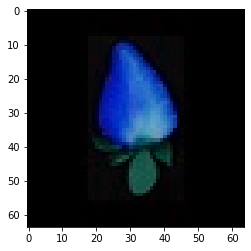

In [6]:
plt.imshow(data[0])

- To split data between train and test (if dae/ae models were not still trained)

In [4042]:
validation_size = int(validation_size * data.shape[0])

validation_data = data[:validation_size]
validation_names = names[:validation_size]

train_data = data[validation_size:]
train_names = names[validation_size:]


In [4043]:
# Add noise to all images 
pure = data
noise_factor=0.5
noise = np.random.normal(0, 1, pure.shape)
noisy_input = pure + noise_factor * noise


- Traditional ae model (you only run it once keep the model and then use it)

# Defining model architecture 

In [15]:
#ENCODER
inp = tf.keras.layers.Input((64, 64, 3))
#inp = tf.keras.layers.Reshape((1,64, 64,3))
e = tf.keras.layers.Conv2D(32, (3, 3), strides=2,activation='relu')(inp)
e = tf.keras.layers.MaxPooling2D((2, 2))(e)
e = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(e)
e = tf.keras.layers.MaxPooling2D((2, 2))(e)
l = tf.keras.layers.Dropout(0.5)(e)
l = tf.keras.layers.Flatten()(l)

l = tf.keras.layers.Dense(16, activation='softmax')(l)

encoder = keras.Model(inputs = inp, outputs = e)
encoder.summary()

#DECODER
d = tf.keras.layers.Reshape((4,4,1))(l)
d = tf.keras.layers.Conv2DTranspose(16,(3, 3), strides=2,activation='relu', padding='same')(d)
d = tf.keras.layers.BatchNormalization()(d)
d = tf.keras.layers.Conv2DTranspose(32,(3, 3), strides=2, activation='relu', padding='same')(d)
d = tf.keras.layers.BatchNormalization()(d)
d = tf.keras.layers.Conv2DTranspose(64,(3, 3),strides=4, activation='relu', padding='same')(d)

decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d)
decoded = layers.Reshape((64,64,3))(decoded)

#decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='softmax', padding='same')(d)
#decoded = layers.Reshape((64,64,1))(decoded)


ae3 = keras.Model(inp, decoded)
ae3.summary()
#from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

ae3.compile(optimizer=keras.optimizers.Adam(lr=0.001),  # Optimizer
              # Loss function to minimize
              loss="mean_squared_error",
              # List of metrics to monitor
              metrics=["mean_squared_error"])


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 31, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
Total params: 5,520
Trainable params: 5,520
Non-trainable params: 0
_________________________________________________________________
Model: "functional_3"
_________________________________________________________________
Layer (type)                 O

In [20]:
if (os.path.exists('/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/my_model_dae.h5') or
os.path.exists('/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/my_model_nae_dropout.h5')) is False:
    history3 = ae3.fit( pure, pure,
                    batch_size=50,
                    epochs=300, shuffle = True, 
                validation_split = 1/6,callbacks=[callback])
    tr_loss = history3.history['loss']
    val_loss = history3.history['val_loss']
    epochs = range(1, len(tr_loss)+1)

    fig = plt.figure(figsize=(8, 4))
    fig.tight_layout()
    plt.plot(epochs, tr_loss,'r')
    plt.plot(epochs, val_loss,'b')
    plt.title('Model loss')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Training','test'], loc='upper right')
    plt.show()
    ae3.save('/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/my_model...')

else:
    
    modeld = keras.models.load_model('/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/my_model_dae.h5')
    modeln = keras.models.load_model('/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/my_model_nae_dropout.h5')

   

## Normal Autoencoder

In [1279]:
total_pixels = img_size * img_size * 3
translator_factor = 2
translator_layer_size = int(total_pixels/translator_factor)
middle_factor = 2
middle_layer_size = int(translator_layer_size/middle_factor)

inputs = keras.Input(shape=(img_size,img_size,3), name='str_image')
x = layers.Flatten(name = 'flattened_img')(inputs) #49152 #3072
x = layers.BatchNormalization()(x)
x = layers.Dense(translator_layer_size, activation='relu', name='encoder')(x)
x = layers.Dense(middle_layer_size, activation='relu', name='middle_layer')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(translator_layer_size, activation='relu', name='decoder')(x)

outputs = layers.Dense(total_pixels, activation='sigmoid', name='reconstructed_str')(x)
outputs = layers.Reshape((img_size,img_size,3))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),  # Optimizer
              # Loss function to minimize
              loss="mean_squared_error",
              # List of metrics to monitor
              metrics=["mean_squared_error"])
x_train = train_data
x_valid = validation_data

In [1280]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [1281]:
history = model.fit(x_train, 
                    x_train, #we pass it the input itself as desired output
                    batch_size=256,
                    epochs=200,
                    callbacks=[callback],
                    # We pass it validation data to
                    # monitor loss and metrics
                    # at the end of each epoch
                    validation_data=(x_valid, x_valid))

Epoch 1/200
6/6 [==============================] - 14s 2s/step - loss: 0.0597 - mean_squared_error: 0.0597 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 2/200
6/6 [==============================] - 10s 2s/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 4/200
6/6 [==============================] - 8s 1s/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 5/200
6/6 [==============================] - 8s 1s/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 6/200
6/6 [==============================] - 8s 1s/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 7/200
6/6 [==============================] -

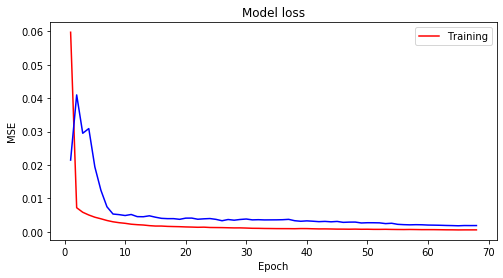

In [1283]:
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(tr_loss)+1)

fig = plt.figure(figsize=(8, 4))
fig.tight_layout()
plt.plot(epochs, tr_loss,'r')
plt.plot(epochs, val_loss,'b')
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

In [1284]:
model.save('/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/my_model_normalae.h5')



## Auxiliary function 

In [7]:
## Compute classes and centroids
def centroid_histogram(clt):
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

## Plot average cluster colors
def plot_colors(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    percentage = []
    for (percent, color) in zip(hist, centroids):
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
        percentage.append(percent)
    return bar, percentage

# Decoder in action for all images 

In [8]:
model = keras.models.load_model('/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/my_model_normalae.h5')
   
# Predict
#decoded_imgsd = modeld.predict(noisy_input)
#decoded_imgsn = modeln.predict(data)
ecoded_img = model.predict(data)

In [10]:
# Pick randomly some images 
num_images = 1
random_test_images = np.random.randint(ecoded_img.shape[0], size= num_images)
random_test_images

array([1061])

In [27]:
names[1]

'I-001_4_2479.JPG'

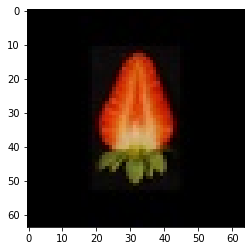

In [33]:
# or simply pick the first image
#convert to rgb from bgr
img = cv2.cvtColor((data[1061]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(img)

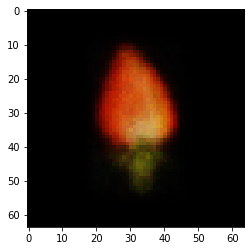

In [49]:
#convert to rgb from bgr
img = cv2.cvtColor((ecoded_img[0]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [35]:
nombres=names[1061].split(".")[0].split("_")

In [36]:
nombres

['I-343', '6']

In [1916]:
###esto creo que lo voy a eliminar por ser mas subjetivo
import pandas as pd
#convert to rgb from bgr
table = pd.DataFrame()
for i in range(0,len(ecoded_img)):
    img = cv2.cvtColor((ecoded_img[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    img = img.reshape((ecoded_img[i].shape[0] * ecoded_img[i].shape[1], 3))
    #m=img.reshape(64*64*3)
    k=5
    kmeans=KMeans(n_clusters=k)
    km = KMeans()
    y_pred=kmeans.fit_predict(img)
    clt=kmeans.fit(img)


    Predi=y_pred.reshape(64,64)
    im = Image.fromarray((Predi * 255).astype(np.uint8))
    #plt.imshow(im)
    imgray = cv2.medianBlur((Predi * 255).astype(np.uint8),5,0)

    contours, hierarchy  = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img = cv2.cvtColor((data[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    res = cv2.bitwise_or(img,img,mask = imgray)
    #plt.imshow(res)
    res = res.reshape((decoded_imgsn[i].shape[0] * decoded_imgsn[i].shape[1], 3))

    k=3
    kmeans=KMeans(n_clusters=k)
    km = KMeans()
    y_pred=kmeans.fit_predict(res)
    clt=kmeans.fit(res)
    Predi=y_pred.reshape(64,64)
    im = Image.fromarray((Predi * 255).astype(np.uint8))
    imgray = cv2.medianBlur((Predi * 255).astype(np.uint8),5,0)

    contours, hierarchy  = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area=cv2.contourArea(contours[0])
    areatot=area*1000*1000/(64*64)
    nombres=names[i].split(".")[0].split("_")
    hist1 = centroid_histogram(clt)
    bar1,percent1 = plot_colors(hist1, clt.cluster_centers_)
    index=[]
    for c in range(0,len(clt.cluster_centers_)):
        if (clt.cluster_centers_[c][0]<60 and  clt.cluster_centers_[c][1]<60 and  clt.cluster_centers_[c][0]<60):
            index.append(c)
    (hist, _) = np.histogram(clt.labels_, bins = 3)
    hist = hist.astype("float")
    hist = np.delete(hist, index)
    areas=hist/np.sum(hist)
    arr=np.delete(clt.cluster_centers_,index,0)
    try:
        if(arr[0][1]<60 and arr[0][2]<60):
            oscuro=areas[0]
            claro=areas[1]
            osc_patt=arr[0]
            clear_patt=arr[1]
        else:
            oscuro=areas[1]
            claro=areas[0]
            osc_patt=arr[1]
            clear_patt=arr[0]
        temp = pd.DataFrame({
        'Individuo': nombres[0],
        'Rep': nombres[1],
        'Area': areatot,
        'dark':oscuro,
        'clear':claro,
        'dark-color-R':osc_patt.ravel()[0],
        'dark-color-G':osc_patt.ravel()[1], 
        'dark-color-B':osc_patt.ravel()[2],
        'clear-color-R':clear_patt.ravel()[0],
        'clear-color-G':clear_patt.ravel()[1], 
        'clear-color-B':clear_patt.ravel()[2]},index=[0])
        table= pd.concat([table, temp])
    except:
        continue
    #plt.imshow(im)


In [1917]:
table.to_csv("/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/innerPatt.csv",index=False)

In [1918]:
table

,Individuo,Rep,Area,dark,clear,dark-color-R,dark-color-G,dark-color-B,clear-color-R,clear-color-G,clear-color-B
0,I-037,3,130737.304688,0.624357,0.375643,173.340659,54.851648,10.651099,201.858447,117.397260,49.305936
0,I-436,12,968994.140625,0.384401,0.615599,140.297101,37.717391,9.724638,231.705882,86.628959,19.868778
0,I-084,3,20385.742188,0.672131,0.327869,137.544715,21.349593,9.186992,201.483333,110.300000,43.816667
0,I-319,13,85449.218750,0.473684,0.526316,173.735450,70.211640,33.031746,220.276190,137.604762,78.819048
0,I-097,3,140258.789062,0.317308,0.682692,126.646465,26.833333,7.616162,195.504695,68.852113,16.098592
...,...,...,...,...,...,...,...,...,...,...,...
0,I-239,1,127441.406250,0.432709,0.567291,141.740157,37.381890,9.590551,193.201201,90.417417,32.222222
0,I-296,1,174072.265625,0.577023,0.422977,183.813212,52.913440,12.198178,224.538226,113.354740,44.045872
0,I-353,4,158203.125000,0.745324,0.254676,183.783784,46.314672,7.959459,84.271186,26.514124,6.107345
0,I-076,7,126220.703125,0.553792,0.446208,177.535032,31.627389,7.235669,224.106719,114.699605,41.055336


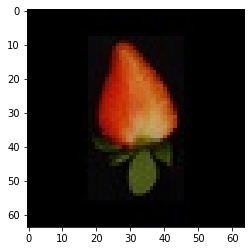

In [66]:
img = cv2.cvtColor((data[0]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(img)

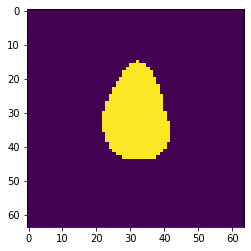

In [281]:
i=3
img = cv2.cvtColor((ecoded_img[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
imgray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
imgray = cv2.medianBlur(imgray,5,0)
ret,thresh1 = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

contours, hierarchy  = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(thresh1)

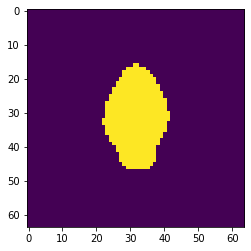

In [310]:
i=4
img = cv2.cvtColor((ecoded_img[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
imgray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
imgray = cv2.medianBlur(imgray,5,0)
ret,thresh1 = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

contours, hierarchy  = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.cvtColor((data[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
res = cv2.bitwise_or(img,img,mask = thresh1)
#plt.imshow(res)
res = res.reshape((ecoded_img[i].shape[0] * ecoded_img[i].shape[1], 3))

k=5
kmeans=KMeans(n_clusters=k)
km = KMeans()
y_pred=kmeans.fit_predict(res)
clt=kmeans.fit(res)
Predi=y_pred.reshape(64,64)
im = Image.fromarray((Predi * 255).astype(np.uint8))
imgray = cv2.medianBlur((Predi * 255).astype(np.uint8),5,0)
plt.imshow(thresh1)

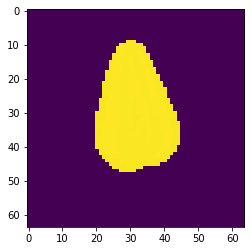

In [254]:
plt.imshow(im)

In [189]:
contours, hierarchy  = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
ar=cv2.contourArea(contours[0])
areatot=ar
areatot

429.5

In [176]:
478/4096

0.11669921875

In [168]:
hist

array([107.,  74.,  97., 244.])

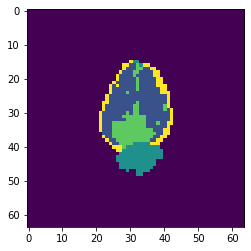

In [159]:
plt.imshow(Predi)
index=[]
for c in range(0,len(clt.cluster_centers_)):
    if (clt.cluster_centers_[c][0]<=70 and  clt.cluster_centers_[c][1]<=70 and  clt.cluster_centers_[c][2]<=70):
        index.append(c)
(hist, _) = np.histogram(clt.labels_, bins = 5)
hist = hist.astype("float")
hist = np.delete(hist, index)
areas=hist/np.sum(hist)
arr=np.delete(clt.cluster_centers_,index,0)
arr=arr.astype(int)


In [156]:
arr

array([[173,  55,   8],
       [122,  30,   8],
       [184,  92,  30]])

In [128]:
index

[0, 5]

In [109]:
clt.cluster_centers_

array([[8.54602810e-02, 8.57470605e-02, 1.14711787e-03],
       [1.97218579e+02, 9.36448087e+01, 3.16939891e+01],
       [1.73195402e+02, 3.91494253e+01, 8.59770115e+00],
       [8.03478261e+01, 8.33623188e+01, 2.53333333e+01],
       [1.95188235e+02, 1.42976471e+02, 7.65764706e+01],
       [6.53469388e+01, 2.18367347e+01, 3.84693878e+00]])

# Reference with four colour -clustering. 

In [76]:
import pandas as pd

In [313]:
## import pandas as pd
#convert to rgb from bgr
table3 = pd.DataFrame()
for i in range(0,len(data)):
    print(i)
    img = cv2.cvtColor((ecoded_img[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    imgray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    imgray = cv2.medianBlur(imgray,5,0)
    ret,thresh1 = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    contours, hierarchy  = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ar=cv2.contourArea(contours[0])
    areatot=ar
   
    img = cv2.cvtColor((data[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    res = cv2.bitwise_or(img,img,mask = thresh1)
    #plt.imshow(res)
    res = res.reshape((ecoded_img[i].shape[0] * ecoded_img[i].shape[1], 3))

    k=5
    kmeans=KMeans(n_clusters=k)
    km = KMeans()
    y_pred=kmeans.fit_predict(res)
    clt=kmeans.fit(res)
    Predi=y_pred.reshape(64,64)
    im = Image.fromarray((Predi * 255).astype(np.uint8))
    imgray = cv2.medianBlur((Predi * 255).astype(np.uint8),5,0)

    contours, hierarchy  = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    nombres=names[i].split(".")[0].split("_")
    hist1 = centroid_histogram(clt)
    bar1,percent1 = plot_colors(hist1, clt.cluster_centers_)
    index=[]
    for c in range(0,len(clt.cluster_centers_)):
        if (clt.cluster_centers_[c][0]<=70 and  clt.cluster_centers_[c][1]<=70 and  clt.cluster_centers_[c][2]<=70):
            index.append(c)
    (hist, _) = np.histogram(clt.labels_, bins = 5)
    hist = hist.astype("float")
    hist = np.delete(hist, index)
    areas=hist/np.sum(hist)
    arr=np.delete(clt.cluster_centers_,index,0)
    arr=arr.astype(int)
    if (i==0):
        reference=arr
        colors=[]
        for j in range(0,arr.shape[0]):
            colors.append(rgb2hex(arr[j][0],arr[j][1],arr[j][2]))
        temp = pd.DataFrame({
        'Individuo': nombres[0],
        'Rep': nombres[1],
        'Area': areatot-areas[2]*areatot,
        str(colors[0]):areas[0],
        str(colors[1]):areas[1],
        str(colors[2]):areas[2],
        str(colors[3]):areas[3]
       
        },index=[0])
        table3= pd.concat([table3, temp])
    else:
        try:
            indices=[]
            for s in range(0,arr.shape[0]):
                distances=[]
                for j in range(0,reference.shape[0]):
                    distances.append(distance.euclidean(arr[s], reference[j]))
                print(distances)
                indices.append(np.argmin(distances))
            print(indices)
            if(len(np.unique(indices))==len(reference)):
                area=areas[indices]
            else:
                area=np.zeros(4)
                for inx in np.unique(indices):
                    area[inx]=np.sum(areas[np.where(np.array(indices)==inx)])
    


            temp = pd.DataFrame({
            'Individuo': nombres[0],
            'Rep': nombres[1],
            'Area': areatot-areas[2]*areatot,
            str(colors[0]):area[0],
            str(colors[1]):area[1],
            str(colors[2]):area[2],
            str(colors[3]):area[3]
           
           
             },index=[0])
            table3= pd.concat([table3, temp])
        except:
            continue
       

0
1
[48.31148931672465, 78.80355321938218, 125.79745625409124, 16.673332000533065]
[135.49907748763457, 22.0, 170.00294115102832, 75.19308478842984]
[30.23243291566195, 109.35264057168442, 84.26743143112884, 57.67148342118486]
[90.74690077352504, 40.92676385936225, 144.27057912131636, 29.949958263743873]
[3, 1, 0, 3]
2
[15.394804318340652, 111.4136436887332, 117.93218390244455, 49.76946855251722]
[39.02563260217571, 131.31260411704582, 76.3544366752843, 80.67837380611982]
[86.97125962063559, 37.73592452822641, 137.11673858431726, 26.115129714401192]
[52.592775169218825, 74.79304780526061, 128.23026163897507, 13.19090595827292]
[0, 0, 3, 3]
3
[32.341923257592455, 91.40021881811882, 106.061303028013, 32.61901286060018]
[13.74772708486752, 123.37341690980274, 100.0499875062461, 65.50572494064927]
[66.73829485385434, 55.58776843874919, 112.8317331250389, 16.911534525287763]
[86.05811989580066, 156.3905367981068, 40.95119045888654, 117.983049630021]
[0, 0, 3, 2]
4
[9.433981132056603, 114.44

[96.90201236300514, 149.83324063771698, 21.563858652847824, 117.80492349643117]
[3, 1, 0, 2]
51
[18.466185312619388, 136.81008734738825, 123.96773773849388, 76.97402159170326]
[121.21881042148533, 28.460498941515414, 167.88984483881092, 60.909769331364245]
[56.462376853972415, 80.14985963805552, 137.33535597216036, 22.58317958127243]
[106.23088063270491, 163.20845566330195, 25.13961017995307, 131.3202193114221]
[0, 1, 3, 2]
52
[111.05854312028409, 42.638011210655684, 168.38942959699102, 52.24940191045253]
[48.05205510693585, 110.3675676999362, 67.20119046564577, 67.47592163134935]
[68.62215385719105, 60.83584469702052, 137.8259772321604, 12.68857754044952]
[146.8672870315238, 33.436506994600975, 181.8213408816468, 86.86771552193599]
[1, 0, 3, 1]
53
[66.34003316248794, 128.03515142334936, 46.3033476111609, 88.9325587172662]
[64.64518543557594, 65.4446330878247, 135.9632303234959, 11.874342087037917]
[30.331501776206203, 94.847245611035, 118.15667564721005, 32.89376840679705]
[97.8825827

[26.343879744638983, 140.09282636880448, 101.75952043912157, 83.84509526501833]
[84.01190391843289, 114.88254871824527, 40.0374824383352, 87.34987120768983]
[0, 3, 0, 2]
101
[55.74047003748713, 81.89627586160435, 143.52003344481216, 26.476404589747453]
[11.445523142259598, 119.5449706177554, 123.05283418109475, 59.16924876994806]
[112.5433249908674, 25.41653005427767, 160.00312496948303, 52.687759489277965]
[73.27346040688948, 111.8257573191436, 46.968074263269514, 79.52986860293433]
[3, 0, 1, 2]
102
[15.165750888103101, 128.2575533838066, 127.10232098588916, 67.12674578735364]
[100.56838469419701, 133.04886320446334, 16.583123951777, 109.24284873619875]
[37.603191353926334, 148.57321427498294, 99.05049217444606, 93.92550239418472]
[30.28200785945344, 97.26767191621273, 124.2095004417939, 35.05709628591621]
[0, 2, 0, 0]
103
[3.605551275463989, 121.80722474467596, 115.57681428383462, 61.40846847137616]
[27.477263328068172, 143.23058332632735, 105.21406750050109, 86.37708029332781]
[27.3

[36.72873534441391, 92.20086767487604, 125.17987058628876, 29.8496231131986]
[37.77565353504821, 133.1277581873893, 80.11242100947892, 82.32253640407346]
[55.263007518592396, 68.65857557508748, 123.04877081872861, 6.48074069840786]
[10.723805294763608, 112.4055158788927, 105.30906893520614, 53.600373133029585]
[3, 0, 3, 0]
151
[121.07435731813736, 29.58039891549808, 169.49926253526885, 61.84658438426491]
[63.25345840347388, 63.56886030125127, 134.99629624548965, 11.874342087037917]
[166.33099530754933, 55.263007518592396, 202.36847580589225, 107.89810007595129]
[63.095166217389426, 106.86907878334125, 56.231663678038196, 70.51950084905593]
[1, 3, 1, 2]
152
[25.709920264364882, 97.88258272031854, 115.26491226735047, 36.4828726939094]
[86.73522929006414, 35.59494346111537, 127.67928571228772, 28.089143810376278]
[22.759613353482084, 140.03570973148243, 107.34523743510934, 82.42572413997951]
[100.81170566953026, 151.27127949482016, 17.378147196982766, 120.8345976945345]
[0, 3, 0, 2]
153
[

[112.12047092302102, 160.4836440264241, 15.937377450509228, 132.48773528142144]
[42.76680956068619, 82.39538822045807, 96.7574286553751, 32.449961479175904]
[0, 1, 2, 3]
200
[32.09361307176243, 90.29950165975447, 111.00900864344298, 30.099833886584822]
[33.0, 141.93308282426617, 93.65895579174476, 87.32124598286491]
[91.37286249209882, 34.48187929913333, 117.07262703125782, 40.01249804748511]
[105.55093557141026, 155.42522317822161, 16.06237840420901, 125.79745625409124]
[3, 0, 1, 2]
201
[71.50524456289902, 59.135437767890075, 139.43457247038842, 14.798648586948742]
[135.1628647225265, 20.12461179749811, 168.5882558187254, 75.29276193632427]
[17.08800749063506, 109.6540012949824, 121.61003248087717, 48.062459362791664]
[80.33679107357973, 112.5433249908674, 40.26164427839479, 85.00588214941364]
[3, 1, 0, 2]
202
[105.28532661297109, 32.69556544854363, 157.797338380595, 45.2658811910251]
[74.79973261984297, 128.1054253339803, 38.13135192987524, 92.78469701410896]
[158.97798589741913, 46.

[91.43850392476902, 131.03053079339944, 26.570660511172846, 102.31813133555558]
[34.40930106817051, 106.33908030446756, 136.82470537150812, 44.87761134463375]
[0, 1, 2, 0]
250
[61.26989472816156, 78.4219357067906, 144.28790663115188, 24.698178070456937]
[119.13437790998869, 27.730849247724095, 165.30577727351212, 58.540584213005594]
[11.445523142259598, 119.5449706177554, 123.05283418109475, 59.16924876994806]
[75.67033764957046, 86.1278120005379, 68.38859554048467, 60.663003552412405]
[3, 1, 0, 3]
251
[21.72556098240043, 105.01428474260061, 120.91732712891069, 43.05810028322197]
[84.66994744299774, 36.89173349139343, 126.87789405566282, 26.43860813280457]
[20.322401432901575, 139.30183056945089, 111.79445424527998, 80.92589202474076]
[95.60857702110204, 147.42116537322585, 20.09975124224178, 116.14215427655886]
[0, 3, 0, 2]
252
[8.54400374531753, 129.0929897399545, 115.14338886796757, 69.40461079784254]
[102.00980345045274, 141.54151334502538, 12.68857754044952, 115.09126813099246]
[4

[109.00458705944443, 16.186414056238647, 148.435171034361, 49.09175083453431]
[5.385164807134504, 125.686116973992, 115.81882403132921, 65.52098900352466]
[89.09545442950498, 131.26309458488322, 26.13426869074396, 101.65628362280415]
[3, 1, 0, 2]
300
[97.86214794290998, 29.68164415931166, 146.78555787270082, 37.48332962798263]
[49.98999899979995, 78.91134265744057, 131.64345787011217, 18.027756377319946]
[90.75791976461338, 140.95744038538726, 23.021728866442675, 109.27488274987991]
[10.04987562112089, 112.48555462813881, 116.37869220780924, 52.04805471869242]
[1, 3, 2, 0]
301
[38.01315561749642, 98.73702446397704, 136.19104228986575, 37.69615364994153]
[66.76825593049439, 60.778285596090974, 136.61991070118586, 12.083045973594572]
[68.93475175845634, 134.2683879399764, 45.35416188179427, 95.44631999192006]
[6.708203932499369, 119.41942890501528, 116.42164747159353, 60.07495318350236]
[3, 3, 2, 0]
302
[50.457903246171455, 72.97944916207575, 122.25792407856433, 10.862780491200215]
[6.0,

[53.16013544000805, 70.01428425685718, 118.87388274974448, 9.273618495495704]
[11.224972160321824, 113.18127053536729, 115.32129031536198, 52.09606511052442]
[101.4051280754578, 22.15851980616034, 128.66234880492428, 46.52956049652737]
[77.6530746332687, 92.44457799135652, 59.06775770248944, 70.07139216541941]
[3, 0, 1, 2]
350
[61.22907805936653, 68.21290200541243, 130.75167302944922, 11.0]
[22.38302928559939, 109.78615577567146, 123.62847568420473, 47.50789408087881]
[92.16289925995167, 133.90294993016397, 24.1039415863879, 104.76640682967036]
[109.94544101507802, 11.489125293076057, 143.60013927569847, 50.97057974949863]
[3, 0, 2, 1]
351
[14.247806848775006, 127.88666857808127, 101.67595585978034, 69.92138442565336]
[107.39646176667088, 26.870057685088806, 121.96310917650467, 55.80322571321482]
[58.66003750424986, 69.57729514719583, 95.49869109050658, 30.28200785945344]
[0, 1, 3]
352
[41.30375285612676, 82.25569889071517, 112.44998888394787, 22.181073012818835]
[85.59205570612264, 35

[139.38794782907166, 22.02271554554524, 169.81166037701888, 79.37883848986453]
[65.49809157525127, 57.532599454570104, 118.00423721205946, 10.862780491200215]
[77.51773990513398, 131.54847015454038, 35.94440151122286, 96.27564593395361]
[106.8831137270991, 19.8997487421324, 144.72387501722028, 46.36809247747852]
[1, 3, 2, 1]
400
[64.00781202322104, 58.7962583843564, 108.2497113160123, 20.273134932713294]
[74.19568720619817, 143.16773379501402, 43.977266854592045, 104.06248123122954]
[42.44997055358225, 88.26097665446491, 88.48163651289458, 40.93897898091744]
[87.18371407550839, 33.95585369269929, 125.54680402144851, 30.740852297878796]
[3, 2, 3, 3]
401
[12.68857754044952, 111.14405067298924, 105.95281968876525, 51.778373863998475]
[50.46781152378217, 72.18725649309579, 118.43141475132347, 11.180339887498949]
[96.32237538599222, 146.64924138910504, 19.519221295943137, 115.6027681329474]
[85.24083528450434, 38.13135192987524, 117.49468073066116, 32.37282811247729]
[0, 3, 2, 3]
402
[112.5

[21.118712081942874, 114.8303095876694, 129.32517156377563, 52.933921071464184]
[3, 0, 0, 0]
449
[25.553864678361276, 135.07405376311175, 96.45724441429995, 79.88116173416608]
[93.79765455489812, 178.06178702910964, 63.631753079732135, 135.7276685130928]
[42.532340636273474, 97.53460924205315, 138.2967823197633, 36.89173349139343]
[23.366642891095847, 122.69474316367429, 134.91108182799513, 61.204574992397426]
[0, 2, 3, 0]
450
[13.0, 119.03360869939212, 123.4908903522847, 57.48912940721924]
[74.06753674856482, 47.51841748206689, 126.40806936267953, 15.297058540778355]
[27.60434748368452, 140.10710188994705, 101.07917688624102, 84.40379138403677]
[39.824615503479755, 89.20762299265685, 129.0387538687506, 27.313000567495326]
[0, 3, 0, 3]
451
[19.05255888325765, 105.46563421323555, 108.02777420645118, 45.35416188179427]
[79.90619500389191, 42.34383071948026, 117.02136557056579, 27.367864366808018]
[26.248809496813376, 126.96850003051938, 88.58893836140041, 73.21885003194191]
[48.887626246

[17.46424919657298, 136.0036764208968, 108.12955192730617, 77.59510293826537]
[94.89467845985885, 124.34226956268733, 27.85677655436824, 99.96499387285532]
[38.18376618407357, 84.98235110892143, 116.15937327654622, 23.57965224510319]
[1, 0, 2, 3]
499
[24.372115213907882, 120.62338081814819, 135.36986370680884, 59.16079783099616]
[123.50708481702578, 20.445048300260872, 164.68454693747074, 64.31174076325411]
[53.786615435440815, 76.97402159170326, 135.8602222874672, 18.411952639521967]
[23.430749027719962, 137.77155003846042, 104.89041900955492, 81.30805618141414]
[0, 1, 3, 0]
500
[30.23243291566195, 92.11948762341224, 104.02403568406679, 34.583232931581165]
[88.37986195961159, 40.23679907746142, 110.95043938624129, 40.36087214122113]
[21.656407827707714, 136.40014662748717, 101.41991914806479, 79.21489758877429]
[107.69401097554126, 157.28318409798297, 16.522711641858304, 127.82800945019835]
[0, 1, 0, 2]
501
[25.96150997149434, 98.90399385262458, 121.33012816279393, 37.22902093797257]


[78.5175139698144, 122.75585525749882, 36.138621999185304, 90.82400563727631]
[3, 0, 0, 2]
548
[63.984373092185564, 84.29709366283039, 151.07944929738127, 32.802438933713454]
[117.54998936622665, 34.49637662132068, 167.95535120977837, 57.3410847473258]
[96.38983348880731, 136.59795020423988, 17.832554500127006, 109.12836478203089]
[24.351591323771842, 122.804723036209, 135.88230201170424, 61.35959582656978]
[3, 1, 2, 0]
549
[5.0990195135927845, 120.92146211487851, 111.26994203287786, 60.71243694664216]
[79.06326580656784, 42.46174749112429, 126.38829059687451, 20.42057785666214]
[89.71621926942753, 143.2515270424717, 24.657656011875904, 110.58480908334562]
[37.77565353504821, 86.31917515824627, 117.15801295686096, 24.596747752497688]
[0, 3, 2, 3]
550
[75.59100475585703, 58.56620185738529, 143.98958295654586, 19.748417658131498]
[31.843366656181317, 102.61578825892242, 130.60245020672468, 40.496913462633174]
[121.35073135337916, 21.400934559032695, 163.8932579455299, 61.204574992397426]

[41.98809355043403, 137.15319901482428, 77.80745465570763, 86.86195945291587]
[62.161081071680215, 64.77653896280658, 132.75918047351755, 8.12403840463596]
[0, 1, 0, 3]
598
[116.31852818876277, 30.56141357987225, 165.2785527526182, 55.98214000911362]
[73.47108274688756, 61.91930232165088, 142.55174499107332, 19.28730152198591]
[31.670175244226233, 92.10320298447823, 117.03845521878696, 30.4138126514911]
[28.160255680657446, 116.1077086157504, 85.21736912155878, 64.28841264178172]
[1, 3, 3, 0]
599
[149.5259174858994, 37.013511046643494, 185.4427135263071, 89.64373932405988]
[191.33739833080202, 74.55199527846321, 216.26141588364763, 132.80060240827223]
[64.47480127925948, 66.37017402418047, 93.33809511662427, 34.77067730142742]
[96.51424765287247, 34.68429039204925, 148.38463532320318, 35.73513677041127]
[1, 1, 3, 1]
600
[79.48584779695062, 43.382023926967726, 124.62343278854101, 20.92844953645635]
[38.79432948254165, 83.19254774317228, 104.38390680559911, 27.80287754891569]
[114.372199

[72.86288492778748, 51.273774973177076, 108.62780491200216, 27.294688127912362]
[40.0374824383352, 142.50263155464884, 84.86459803710851, 90.13878188659973]
[95.27853903162034, 154.69324484281788, 27.440845468024488, 120.92146211487851]
[23.345235059857504, 100.6429331846007, 100.44899203078147, 43.55456348076513]
[3, 0, 2, 0]
648
[36.52396473549935, 87.46427842267951, 101.09896141899777, 31.78049716414141]
[77.26577508832743, 45.93473631142341, 113.11498574459532, 27.16615541441225]
[107.17275773255068, 164.05486887014357, 25.514701644346147, 132.38579984273238]
[23.388031127053, 128.9147004805891, 92.05433178292046, 73.5187051028512]
[3, 3, 2, 0]
649
[11.789826122551595, 112.68983982595769, 103.3537614216338, 54.3415126767741]
[29.274562336608895, 140.63072210580447, 96.79876032264049, 85.0235261559999]
[56.444663166680336, 65.71149062378664, 107.24271537032247, 19.390719429665317]
[96.52460826131335, 154.98709623707387, 25.96150997149434, 121.37956994486346]
[0, 0, 3, 2]
650
[13.190

[55.937465083787984, 120.56948204251356, 56.65686189686118, 78.86063656856949]
[33.54101966249684, 92.54728521139883, 126.13484847574837, 31.63858403911275]
[3, 1, 0, 3]
697
[16.09347693943108, 106.2214667569602, 106.1602562167217, 47.085029467974216]
[51.43928459844674, 70.44146506142529, 120.6358155772986, 10.488088481701515]
[45.18849411078001, 145.5678535941229, 83.28865468957942, 94.54099639838793]
[14.035668847618199, 131.62446581088184, 106.3202708800161, 73.35529974037323]
[0, 3, 0, 0]
698
[45.5411901469428, 98.41747812253675, 144.10065926289164, 39.496835316262995]
[19.519221295943137, 134.8369385591352, 127.99218726156687, 74.90660852021001]
[108.55873986004075, 41.773197148410844, 167.43356891615252, 50.46781152378217]
[86.21484790916237, 130.17296186228538, 29.563490998188964, 99.2622788374315]
[3, 0, 1, 2]
699
[123.60016181219181, 14.035668847618199, 160.2747640771934, 63.75735251718032]
[22.494443758403985, 130.22288585344742, 95.17877914745492, 74.97999733262199]
[31.192

[31.12876483254676, 106.96261028976434, 134.90737563232042, 45.44227107000705]
[158.09807082946963, 40.13726448077895, 185.72560405070703, 98.73702446397704]
[89.49301648732151, 101.11874208078342, 48.16637831516918, 82.05485969764375]
[3, 0, 1, 2]
747
[34.49637662132068, 93.39164844888434, 127.03149215844077, 31.464265445104548]
[106.19792841670689, 17.4928556845359, 138.9136422386225, 46.88283267892417]
[18.788294228055936, 138.3654581172628, 120.82218339361361, 78.79720807236764]
[95.55626614722867, 139.4668419374297, 19.235384061671343, 110.34944494649713]
[3, 1, 0, 2]
748
[9.0, 129.2168719633779, 111.21151019566275, 69.8927750200262]
[103.26664514740469, 22.360679774997898, 128.37834708392222, 47.01063709417264]
[109.31148155614761, 154.34053258946594, 10.677078252031311, 127.00787377166819]
[47.58150901348127, 75.39230729988306, 111.18003417880388, 17.4928556845359]
[0, 1, 2, 3]
749
[31.016124838541646, 91.85858696931932, 120.2538980657176, 31.68595903550972]
[171.26003620226174,

[135.77186748365804, 22.58317958127243, 170.9824552402965, 75.82875444051551]
[80.92589202474076, 49.52776998815917, 140.60583202698243, 20.85665361461421]
[92.78469701410896, 119.4361754243663, 34.899856733230294, 95.05261700763425]
[19.209372712298546, 104.42700800080408, 114.88254871824527, 43.18564576337837]
[1, 3, 2, 0]
797
[45.12205669071391, 78.02563681252464, 112.8228700219951, 18.49324200890693]
[86.0406880493177, 35.482389998420345, 127.47548783981962, 27.80287754891569]
[14.352700094407323, 118.46518475906751, 98.60527369263775, 61.00819617067857]
[75.37904218017101, 127.4597975833949, 38.06573262134856, 92.40129869217208]
[3, 3, 0, 2]
798
[44.56455991031439, 78.06407624509497, 112.75194011634566, 18.547236990991408]
[99.81482855768475, 21.42428528562855, 134.12680567284082, 41.6293165929973]
[99.84487968844472, 128.68954891520912, 28.071337695236398, 104.73299384625649]
[17.578395831246947, 127.29886095327012, 97.45768312452333, 70.33491309442275]
[3, 1, 2, 0]
799
[56.56854

[30.166206257996713, 93.60555539069249, 118.05507189443408, 31.874754901018456]
[150.49584711878265, 33.12099032335839, 179.42686532400882, 91.44943958275523]
[2, 3, 0, 1]
846
[97.01546268507923, 36.98648401781386, 152.63354808167173, 37.282703764614496]
[23.874672772626646, 100.269636480841, 119.44454780357285, 38.704004960727254]
[133.33041663476493, 29.13760456866693, 175.69860557215586, 74.00675644831355]
[59.23681287847955, 73.68174807915459, 137.59360450253493, 17.11724276862369]
[1, 0, 1, 3]
847
[34.19064199455752, 102.57192598367256, 134.484199815443, 41.0]
[146.11296999240005, 41.916583830269374, 189.63122105813693, 86.86195945291587]
[84.55175929571188, 124.53513560437472, 31.654383582688826, 94.88413987595608]
[84.74668135095321, 57.28874234961002, 153.40469353966978, 29.832867780352597]
[0, 1, 2, 3]
848
[23.93741840717165, 101.61200716450787, 100.48880534666536, 43.9203825119955]
[73.23250644351864, 52.640288753007425, 105.65036677645753, 28.861739379323623]
[25.01999200639

[1, 3, 1, 1]
895
[185.42114226808118, 76.08547824650904, 224.11604137142882, 125.97221915962265]
[134.21624342828255, 38.28837943815329, 181.72781845386248, 74.3370701601832]
[236.98312176186724, 122.73956167430288, 265.05471133333964, 178.44607028455403]
[60.4648658313239, 66.12110101926616, 98.39207285142437, 29.29163703175362]
[1, 1, 1, 3]
896
[160.3184331260757, 55.44366510251645, 203.71303345637952, 101.04454463255303]
[124.77579893553076, 22.825424421026653, 142.8355697996826, 66.79071791798619]
[222.82504347581758, 109.59470790143108, 253.3100866527032, 164.44147895224003]
[73.86474125047755, 82.82511696339462, 74.83982896827064, 55.5517776493246]
[1, 1, 1, 3]
897
[132.46508974065583, 11.789826122551595, 157.95568998931313, 73.60027173862879]
[22.561028345356956, 99.18165152889924, 110.36303729057116, 39.102429592034305]
[89.52094726934027, 120.37441588643328, 33.24154027718932, 94.27618999514141]
[83.6719785830358, 39.102429592034305, 132.4688642662871, 23.430749027719962]
[1, 

[79.23383115816122, 127.47548783981962, 33.74907406137241, 95.27853903162034]
[100.069975517135, 29.154759474226502, 119.87076374162301, 47.53945729601885]
[3, 3, 2, 1]
945
[47.853944456021594, 84.08329203831163, 133.37541002748594, 23.280893453645632]
[112.65433857601757, 14.798648586948742, 151.94077793666847, 52.81098370604357]
[8.774964387392123, 119.21828718783037, 119.69962405956002, 58.111960903070546]
[86.4060183089118, 129.94614268996213, 27.294688127912362, 99.80981915623332]
[3, 1, 0, 2]
946
[117.81341180018512, 4.47213595499958, 148.2868841131946, 59.447455790807396]
[52.46903848937962, 71.56116265125938, 123.50708481702578, 9.219544457292887]
[88.12491134747314, 127.85147633093644, 27.910571473905726, 98.92421341612983]
[3.7416573867739413, 121.49897118905987, 109.5673308974897, 61.91930232165088]
[1, 3, 2, 0]
947
[30.28200785945344, 97.8008179924892, 123.29639086364207, 35.482389998420345]
[10.04987562112089, 129.4488315899375, 109.34349546269316, 70.43436661176133]
[91.5

994
[39.01281840626232, 98.37682653958706, 135.30336285547378, 37.013511046643494]
[4.123105625617661, 123.55160864998885, 113.46365056704283, 64.19501538281614]
[75.93418202627852, 57.07889277132134, 144.12147653975794, 19.6468827043885]
[70.46985170979147, 133.3641631023867, 42.74342054632502, 94.79451460923254]
[3, 0, 3, 2]
995
[46.49731175025068, 83.46256645946133, 129.47200469599596, 21.77154105707724]
[84.32081593533118, 42.35563716909474, 140.29611541307906, 23.790754506740637]
[57.56735185849702, 122.30290266383705, 54.96362433464518, 81.03085831953157]
[8.306623862918075, 119.41942890501528, 119.80818002123227, 58.489315263559035]
[3, 3, 2, 0]
996
[103.56157588603989, 39.96248240537617, 161.49922600433726, 44.73253849269008]
[59.07622195096772, 82.06095295571457, 144.88961315429066, 27.27636339397171]
[79.63039620647382, 119.78731151503484, 36.11094017053558, 89.71621926942753]
[22.67156809750927, 101.41991914806479, 120.6358155772986, 40.29888335921977]
[1, 3, 2, 0]
997
[64.9

[76.16429609731846, 46.14108798023731, 118.0084742719776, 21.42428528562855]
[84.20213774008353, 157.3975857502268, 44.23799272118933, 117.76247280012423]
[3, 0, 3, 2]
1044
[42.2965719651132, 84.59905436823747, 126.19825672330026, 22.38302928559939]
[81.2773031048644, 132.34047000067667, 33.03028912982749, 98.41747812253675]
[99.25220400575496, 24.71841418861655, 143.71499573809268, 40.01249804748511]
[7.681145747868608, 123.49493916756265, 106.51760417883985, 65.21502894272147]
[3, 2, 1, 0]
1045
[35.84689665786984, 86.37708029332781, 108.09255293497328, 27.65863337187866]
[81.36952746575342, 39.66106403010388, 123.06096050332128, 25.632011235952593]
[17.029386365926403, 128.895306353645, 99.22197337283713, 71.86097689288673]
[82.58934555982388, 121.93850909372314, 35.07135583350036, 91.8313671900838]
[3, 3, 0, 2]
1046
[109.64032105024137, 13.45362404707371, 146.54692081377897, 50.24937810560445]
[7.54983443527075, 115.13904637437292, 107.19141756689292, 56.64803615307419]
[50.28916384

[123.17061337835418, 33.74907406137241, 173.5684303092011, 64.96922348312314]
[0, 3, 0, 1]
1093
[76.96102909914862, 56.382621436041795, 146.78555787270082, 26.1725046566048]
[60.77005841695399, 118.37651794169315, 54.57105459856901, 80.52949770115296]
[29.9833287011299, 94.71536306217698, 121.92620719107111, 36.51027252705737]
[126.96456198483102, 35.832945734337834, 176.58142597679972, 69.7853852894716]
[3, 2, 0, 1]
1094
[66.34003316248794, 58.31809324729333, 132.54433220624713, 14.866068747318506]
[16.61324772583615, 136.14697940094007, 119.9208072020865, 76.58981655546643]
[41.15823125451335, 139.7497763862254, 84.81155581640984, 89.11789943664516]
[24.392621835300936, 103.24243313676794, 125.81732790041282, 42.15447781671598]
[3, 0, 0, 0]
1095
[32.66496594212215, 95.17877914745492, 125.11594622589081, 32.93933818400121]
[79.56129712366435, 43.05810028322197, 132.7893067984015, 20.09975124224178]
[11.180339887498949, 131.10682667199293, 112.08032833642129, 72.06247289678588]
[53.572

[97.29850975220535, 66.83561924602779, 173.25703448922354, 48.425200051213004]
[157.25457068079135, 51.54609587543949, 199.7248106770914, 98.56469956328178]
[44.721359549995796, 98.69143833180262, 76.58328799418317, 54.8270006474912]
[3, 3, 1, 0]
1143
[41.352146256270665, 105.65036677645753, 143.59317532529184, 45.58508528016593]
[94.83670175622937, 44.06812907306141, 155.54742042219794, 36.24913792078372]
[27.586228448267445, 135.9742622704753, 139.04675472660267, 75.22632517942107]
[86.2670273047588, 127.71061036577971, 28.231188426986208, 98.20386957752734]
[0, 3, 0, 2]
1144
[106.41898326896381, 44.14748010928823, 166.76330531624757, 52.81098370604357]
[48.92851929090027, 87.66983517721475, 141.52384958020326, 32.341923257592455]
[176.0284067984483, 69.8426803609369, 214.68348795377813, 119.68291440301745]
[49.56813492557492, 113.95174417269794, 66.96267617113283, 71.95137246779939]
[1, 3, 1, 0]
1145
[113.86395390991831, 31.064449134018133, 164.98484778912274, 54.415071441651165]
[2

[13.0, 119.63695081370136, 100.52860289489753, 63.0]
[2, 3, 3, 0]
1192
[14.52583904633395, 131.190700889964, 124.55520864259351, 70.8590149522275]
[59.21148537234985, 79.68688725254614, 143.94790724425278, 25.019992006393608]
[89.31965069345043, 144.8516482474397, 26.019223662515376, 111.46299834474219]
[38.49675310984031, 111.31037687475504, 144.17697458332242, 50.93132631298737]
[0, 3, 2, 0]
1193
[69.29646455628166, 82.78888814327681, 157.1146078504478, 35.94440151122286]
[121.67168939404104, 31.622776601683793, 170.2028201881508, 61.56297588648554]
[38.40572873934304, 106.14612569472331, 77.98717843338096, 58.86425061104575]
[29.171904291629644, 124.46284586172695, 141.04609175726918, 63.56886030125127]
[3, 1, 0, 0]
1194
[39.57271787481876, 115.73245007343446, 147.6787053031005, 55.89275444992848]
[94.09569596958194, 138.80201727640704, 19.4164878389476, 109.43491216243562]
[21.213203435596427, 139.96428115772966, 119.95415791042844, 81.06787279804497]
[75.08661665037252, 68.7749954

[16.911534525287763, 105.49881515922347, 115.06954418958998, 44.63182720884279]
[11.789826122551595, 131.829435256319, 113.35784048754634, 72.69800547470336]
[52.744667976962376, 68.89121859859934, 118.91593669479293, 9.486832980505138]
[53.103672189407014, 140.93970341958294, 68.70953354520753, 94.09569596958194]
[0, 0, 3, 0]
1242
[72.47758274114831, 56.542019772908716, 140.88293012285058, 17.916472867168917]
[129.78443666326098, 25.298221281347036, 171.11691909334974, 70.8942874990644]
[20.223748416156685, 104.31203190428226, 121.2023102090055, 44.05678154382138]
[76.03288762108144, 124.8559169603107, 37.33630940518894, 91.18662182579197]
[3, 1, 0, 2]
1243
[11.74734012447073, 117.80492349643117, 122.2906374175881, 56.515484603779164]
[67.91170738539859, 59.665735560705194, 135.9301291105103, 10.862780491200215]
[102.49390225764652, 158.26875876179733, 22.759613353482084, 126.41598000252975]
[37.8549864614954, 146.37281168304446, 94.78396488858229, 92.4824307639024]
[0, 3, 2, 0]
1244


[39.433488306260706, 124.65552534885889, 73.60706487831179, 75.4254598925323]
[117.73274820541648, 17.578395831246947, 158.25928092848142, 57.34980383575867]
[3, 0, 0, 1]
1291
[20.322401432901575, 103.13583276436954, 110.73391531053167, 42.532340636273474]
[59.62382074305537, 154.61888629789053, 75.37904218017101, 106.40018796975878]
[64.26507605223851, 58.42944463196617, 109.23827168167757, 19.078784028338912]
[20.049937655763422, 134.8406466908254, 101.74969287422935, 77.5886589650833]
[0, 0, 3, 0]
1292
[67.80855403265875, 103.70149468546728, 54.08326913195984, 72.01388754955533]
[118.86967653695369, 16.186414056238647, 158.16763259276533, 58.532042506647585]
[69.13031173081747, 67.90434448545984, 144.03471803700663, 20.322401432901575]
[16.431676725154983, 111.8659912573969, 122.97560733739029, 50.25932749251625]
[2, 1, 3, 0]
1293
[126.26163312740731, 33.13608305156178, 174.89139487121716, 66.82813778641449]
[28.460498941515414, 93.6269192059634, 103.25211862233142, 37.1752605908822

[56.83308895353129, 106.78014796768171, 158.39507568103247, 51.45872132107443]
[3, 2, 0, 3]
1340
[85.38149682454625, 73.85120175054702, 164.14932226482082, 40.64480286580315]
[27.147743920996454, 126.46343345014795, 87.3040663428686, 73.01369734508724]
[134.78130434151467, 57.706152185014034, 193.56910910576616, 77.67882594375381]
[36.373066958946424, 109.11920087683927, 141.97887166758298, 48.79549159502341]
[3, 0, 1, 0]
1341
[179.3599732381782, 70.58328414008518, 218.6755587622906, 120.55704044144414]
[53.018864567246254, 77.68526243760782, 92.11948762341224, 38.43175770115127]
[117.57976016304848, 46.57252408878007, 177.2173806374533, 60.15812497078013]
[228.31557108528537, 115.29093633065871, 258.1336862945245, 170.3114793547399]
[1, 3, 1, 1]
1342
[66.04543890383347, 76.82447526667526, 149.50919704151983, 27.49545416973504]
[23.259406699226016, 112.98229949863828, 130.9427355755179, 51.254268114957995]
[108.28665661105249, 46.238512086787566, 170.23219436992522, 51.40038910358559]


[58.29236656715869, 85.00588214941364, 147.50254235097103, 30.62678566222711]
[122.61321299109652, 33.793490497431605, 172.89013852733186, 63.13477647065839]
[101.4741346353838, 128.16005617976296, 24.939927826679853, 105.77806956075536]
[16.0312195418814, 121.16517651536682, 128.00781226159597, 59.9749947894954]
[3, 1, 2, 0]
1390
[53.600373133029585, 70.77428911688199, 122.74363527287271, 8.660254037844387]
[89.11228871485683, 37.69615364994153, 142.16187955988764, 28.478061731796284]
[33.25657829663178, 140.87583185202493, 92.14662229295223, 86.66025617317318]
[18.05547008526779, 106.48004507887852, 115.15641536623133, 45.12205669071391]
[3, 3, 0, 0]
1391
[146.49573372627614, 37.8021163428716, 185.8978213965941, 86.35392289873113]
[181.05524018928588, 64.96922348312314, 208.65761428713787, 122.39689538546311]
[88.54942122905152, 38.691084244306204, 142.772546380598, 28.089143810376278]
[66.94027188471824, 79.25276020429824, 76.4198926981712, 50.16971197844373]
[1, 1, 3, 3]
1392
[85.1

[92.74157643689264, 64.81512169239521, 164.79684462998677, 41.72529209005013]
[148.52945835759317, 55.036351623268054, 199.2937530380719, 89.6493167849036]
[34.20526275297414, 99.26731586982696, 131.30498848101698, 37.33630940518894]
[1, 3, 1, 0]
1439
[127.0196835140129, 53.75872022286245, 187.090887004151, 70.07139216541941]
[58.111960903070546, 113.28283188550682, 56.32051136131489, 74.03377607551839]
[84.64632301523794, 63.34824385884742, 158.22136391777187, 33.63034344160047]
[167.14065932620943, 63.84355879804947, 212.15324649884573, 108.47119433287347]
[1, 2, 3, 1]
1440
[44.83302354291979, 95.90620417887469, 140.18915792599654, 35.94440151122286]
[152.45327152934436, 43.15089802078283, 191.55416988413486, 92.5526876973327]
[91.26883367283708, 122.0409767250328, 29.171904291629644, 96.90201236300514]
[96.27564593395361, 60.90155991434045, 167.5291019494822, 43.829214001622255]
[3, 1, 2, 3]
1441
[111.64676439557037, 63.8200595424354, 180.77057282644208, 58.7962583843564]
[47.053161

[95.23129737644027, 140.44571905188138, 19.748417658131498, 110.7925990308017]
[3, 0, 1, 2]
1488
[57.105166141076936, 68.79680225126747, 124.34629065637624, 8.06225774829855]
[74.47147104764348, 126.10313239567049, 40.53393639902249, 90.49861877399013]
[12.12435565298214, 112.0490963818986, 105.13800454640558, 52.92447448959697]
[108.04165863221463, 17.233687939614086, 147.04421103872127, 47.80167361086848]
[3, 2, 0, 1]
1489
[12.529964086141668, 115.60709320798617, 121.79490958164057, 54.286278192559855]
[89.02808545621994, 32.89376840679705, 134.86660075793412, 29.732137494637012]
[84.31488599292535, 129.84991336154215, 32.09361307176243, 97.88258272031854]
[32.7566787083184, 149.93665329064805, 111.91067866830225, 92.72000862812729]
[0, 3, 2, 0]
1490
[12.24744871391589, 125.00399993600205, 124.14104881142256, 63.702433234531945]
[37.77565353504821, 93.99468070055879, 129.20526305069774, 31.89043743820395]
[33.27160951922825, 128.60404348231046, 82.03657720797473, 76.94803441284255]
[

[8.18535277187245, 117.3839852790831, 108.32358930537707, 57.48912940721924]
[61.87083319303208, 61.1228271597445, 116.05602095539895, 10.488088481701515]
[66.12866246946176, 126.63727729227283, 46.968074263269514, 87.42425292789181]
[33.36165463522455, 92.65527507918802, 116.2497311824849, 31.0]
[0, 3, 2, 3]
1538
[75.91442550661897, 70.22107945624305, 152.55818562109343, 29.274562336608895]
[82.3164625090267, 120.48236385463227, 34.36568055487916, 91.26883367283708]
[27.748873851023216, 100.02999550134949, 123.40583454602137, 37.815340802378074]
[119.57006314291216, 32.01562118716424, 169.12125827346483, 59.57348403442592]
[3, 2, 0, 1]
1539
[192.28364465029262, 81.85963596303125, 229.19860383518918, 133.46535130886969]
[48.46648326421054, 88.48163651289458, 140.09282636880448, 29.68164415931166]
[131.70801038661241, 54.872579673275794, 189.3620870184948, 74.08778576796583]
[95.90099061010788, 89.11228871485683, 63.51377803280167, 76.96102909914862]
[1, 3, 1, 2]
1540
[68.22023160324215

[39.6232255123179, 89.69949832635632, 128.09761902549164, 27.568097504180443]
[25.199206336708304, 115.04347004502254, 87.60136985230311, 61.554853586049575]
[76.30203142774116, 54.12947441089743, 139.09349373712632, 17.146428199482248]
[1, 3, 0, 3]
1587
[10.954451150103322, 126.0, 104.02403568406679, 67.54257916307313]
[63.60031446463138, 58.42088667591412, 115.6460116043783, 11.789826122551595]
[31.622776601683793, 91.23595782365635, 108.02314566795395, 31.843366656181317]
[62.13694553162394, 137.6553667678816, 54.4426303552648, 94.91575211733824]
[0, 3, 0, 2]
1588
[111.89727431890377, 18.788294228055936, 153.62942426501507, 51.42956348249516]
[25.573423705088842, 99.24716620639605, 118.35962149314267, 37.416573867739416]
[34.26368339802363, 128.9418473576364, 81.12336284942828, 77.56287771866127]
[66.87301398920195, 58.54912467321779, 130.28046668629952, 6.48074069840786]
[1, 0, 0, 3]
1589
[102.42558274181309, 34.79942528261063, 157.47380734585673, 43.60045871318328]
[61.58733636065

In [312]:
table3

,Individuo,Rep,Area,#C66323,#B82E08,#4C4B14,#C2904E
0,I-001,1,279.150219,0.339912,0.353070,0.135965,0.171053
0,I-001,4,221.017341,0.673410,0.098266,0.000000,0.228324
0,I-002,1,443.619048,0.537415,0.462585,0.000000,0.000000
0,I-002,5,314.686321,0.191038,0.780660,0.028302,0.000000
0,I-003,1,320.439716,0.380615,0.172577,0.269504,0.177305
0,I-004,3,356.176991,0.623894,0.143805,0.000000,0.232301
0,I-004,4,315.796767,0.762125,0.205543,0.032333,0.000000
0,I-004,6,303.422535,0.371831,0.253521,0.059155,0.315493
0,I-004,8,470.878378,0.146959,0.459459,0.060811,0.332770
0,I-005,14,200.377246,0.604790,0.347305,0.047904,0.000000


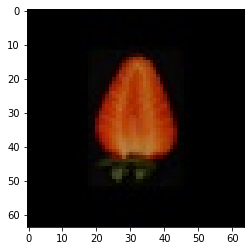

In [157]:
img = cv2.cvtColor((data[3]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [315]:
table3

,Individuo,Rep,Area,#B82E08,#C2904E,#4C4B14,#C66323
0,I-001,1,372.831140,0.353070,0.171053,0.135965,0.339912
0,I-001,4,284.034682,0.101156,0.228324,0.000000,0.670520
0,I-002,1,465.054422,0.481293,0.000000,0.000000,0.518707
0,I-002,5,314.686321,0.780660,0.000000,0.028302,0.191038
0,I-003,1,320.439716,0.269504,0.172577,0.177305,0.380615
...,...,...,...,...,...,...,...
0,P-029,7,537.316388,0.059181,0.365706,0.435508,0.139605
0,P-030,1,358.508314,0.617577,0.000000,0.078385,0.304038
0,P-030,5,253.181102,0.296588,0.275591,0.078740,0.349081
0,P-030,7,299.970379,0.642180,0.000000,0.042654,0.315166


In [316]:
table3.to_csv("/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/datasets/innerPatfourCol.csv",index=False)

# ref with 3 colors 

In [4100]:
## import pandas as pd
#convert to rgb from bgr
table = pd.DataFrame()
for i in range(0,len(ecoded_img)):
    print(i)
    img = cv2.cvtColor((ecoded_img[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    img = img.reshape((ecoded_img[i].shape[0] * ecoded_img[i].shape[1], 3))
    #m=img.reshape(64*64*3)
    k=5
    kmeans=KMeans(n_clusters=k)
    km = KMeans()
    y_pred=kmeans.fit_predict(img)
    clt=kmeans.fit(img)


    Predi=y_pred.reshape(64,64)
    im = Image.fromarray((Predi * 255).astype(np.uint8))
    #plt.imshow(im)
    imgray = cv2.medianBlur((Predi * 255).astype(np.uint8),5,0)

    contours, hierarchy  = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img = cv2.cvtColor((data[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    res = cv2.bitwise_or(img,img,mask = imgray)
    #plt.imshow(res)
    res = res.reshape((ecoded_img[i].shape[0] * ecoded_img[i].shape[1], 3))

    k=4
    kmeans=KMeans(n_clusters=k)
    km = KMeans()
    y_pred=kmeans.fit_predict(res)
    clt=kmeans.fit(res)
    Predi=y_pred.reshape(64,64)
    im = Image.fromarray((Predi * 255).astype(np.uint8))
    imgray = cv2.medianBlur((Predi * 255).astype(np.uint8),5,0)

    contours, hierarchy  = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area=cv2.contourArea(contours[0])
    areatot=area*1000*1000/(64*64)
    nombres=names[i].split(".")[0].split("_")
    hist1 = centroid_histogram(clt)
    bar1,percent1 = plot_colors(hist1, clt.cluster_centers_)
    index=[]
    for c in range(0,len(clt.cluster_centers_)):
        if (clt.cluster_centers_[c][0]<60 and  clt.cluster_centers_[c][1]<60 and  clt.cluster_centers_[c][0]<60):
            index.append(c)
    (hist, _) = np.histogram(clt.labels_, bins = 4)
    hist = hist.astype("float")
    hist = np.delete(hist, index)
    areas=hist/np.sum(hist)
    arr=np.delete(clt.cluster_centers_,index,0)
    arr=arr.astype(int)
    if (i==0):
        reference=arr
        colors=[]
        for j in range(0,arr.shape[0]):
            colors.append(rgb2hex(arr[j][0],arr[j][1],arr[j][2]))
        temp = pd.DataFrame({
        'Individuo': nombres[0],
        'Rep': nombres[1],
        'Area': areatot,
        str(colors[0]):areas[0],
        str(colors[1]):areas[1],
        str(colors[2]):areas[2],
        },index=[0])
        table= pd.concat([table, temp])
    else:
        try:
            indices=[]
            for s in range(0,arr.shape[0]):
                distances=[]
                for j in range(0,reference.shape[0]):
                    distances.append(distance.euclidean(arr[s], reference[j]))
                print(distances)
                indices.append(np.argmin(distances))
            print(indices)
            if(len(np.unique(indices))==len(reference)):
                area=areas[indices]
            else:
                area=np.zeros(3)
                for inx in np.unique(indices):
                    area[inx]=np.sum(areas[np.where(np.array(indices)==inx)])
    


            temp = pd.DataFrame({
            'Individuo': nombres[0],
            'Rep': nombres[1],
            'Area': areatot,
            str(colors[0]):area[0],
            str(colors[1]):area[1],
            str(colors[2]):area[2],
            },index=[0])
            table= pd.concat([table, temp])
        except:
            continue

0
1
[20.46948949045872, 109.88175462741756, 36.4828726939094]
[89.11228871485683, 40.620192023179804, 121.2146855789347]
[95.50916186418976, 166.3640586184408, 47.47630988187688]
[0, 1, 2]
2
[110.44002897500525, 117.00427342623003, 103.42630226397925]
[18.35755975068582, 78.4729252672538, 69.72087205421343]
[107.82856764327346, 185.9516066077408, 54.506880299646575]
[2, 0, 2]
3
[107.9166344916297, 180.0527700425628, 57.043842787806646]
[23.748684174075834, 95.65040512198576, 47.24404724407086]
[111.87493016757597, 18.027756377319946, 154.47977213862015]
[2, 0, 1]
4
[72.97259759663213, 147.50593208410297, 31.12876483254676]
[108.90821823902914, 19.44222209522358, 149.86994361779148]
[15.394804318340652, 97.98979538707079, 46.95742752749558]
[2, 1, 0]
5
[76.4525996941896, 149.00335566691106, 32.63433774416144]
[82.60750571225353, 19.82422760159901, 124.75576139000555]
[19.924858845171276, 110.39021695784459, 36.72873534441391]
[2, 1, 0]
6
[18.49324200890693, 100.42410069301094, 43.703546

[13.601470508735444, 97.25224933131366, 48.46648326421054]
[102.1420579389313, 22.93468988235943, 140.90067423543437]
[2, 0, 1]
90
[140.07854939283175, 211.00947846009194, 88.4420714366189]
[83.39064695755754, 21.18962010041709, 124.65151423067431]
[44.45222154178574, 135.4289481610191, 14.560219778561036]
[2, 1, 2]
91
[21.470910553583888, 107.95369377654477, 37.0]
[95.63994981178107, 15.427248620541512, 136.8612436009552]
[83.95832299420945, 156.8247429457482, 35.22782990761707]
[0, 1, 2]
92
[17.916472867168917, 79.30952023559341, 71.81225522151495]
[111.03603018840326, 20.346989949375804, 152.17424223566877]
[44.77722635447622, 123.46659467240522, 22.11334438749598]
[0, 1, 2]
93
[99.93497886125758, 144.58907289280197, 71.40728254176881]
[18.894443627691185, 83.28265125462805, 61.39218191268331]
[114.0701538527936, 30.675723300355934, 151.55197128378106]
[2, 0, 1]
94
[215.75449010391418, 278.6449353568085, 167.01496938897424]
[109.20622692868754, 177.34993656610087, 61.53048025166064]

[32.77193921634788, 97.82126558167197, 45.232731511594565]
[72.73238618387272, 27.03701166919155, 116.0775602776006]
[2, 0, 1]
178
[10.954451150103322, 107.29864864013899, 49.03060268852505]
[97.49871794028884, 47.843494855622744, 126.15070352558483]
[67.01492371106603, 149.28496240412161, 16.583123951777]
[0, 1, 2]
179
[5.916079783099616, 95.3205119583398, 53.76802023508026]
[92.67685795278129, 171.01461925812075, 40.162171256046406]
[100.60815076324582, 17.291616465790582, 141.23030836190935]
[0, 2, 1]
180
[40.2119385257662, 67.6904720030818, 75.13321502504735]
[100.66777041337511, 10.04987562112089, 143.71499573809268]
[68.22023160324215, 109.87720418721983, 58.9406481131655]
[0, 1, 2]
181
[111.70496855556605, 142.3341139713175, 91.72785836374901]
[31.080540535840107, 127.50294114254777, 38.91015291668744]
[89.19641248391103, 35.34119409414458, 124.1289651934632]
[2, 0, 1]
182
[149.10734388352574, 211.29126815843574, 104.25449630591478]
[88.68483523128404, 42.80186911806539, 119.920

[115.0782342582645, 180.4826861502233, 69.59166616772443]
[82.74055837375042, 19.261360284258224, 125.14791248758407]
[2, 2, 1]
265
[112.05802068571441, 183.76071397336264, 60.40695324215582]
[100.0199980003999, 25.317977802344327, 137.78243719719867]
[22.9128784747792, 109.41663493271945, 35.22782990761707]
[2, 1, 0]
266
[106.92520750505935, 17.944358444926362, 148.05742129322664]
[41.689327171351664, 126.05157674539419, 17.146428199482248]
[29.29163703175362, 69.92138442565336, 74.1215218408257]
[1, 2, 0]
267
[144.19431334140748, 205.1852821232556, 97.59098319004681]
[33.896902513356586, 106.3202708800161, 36.6742416417845]
[105.00952337764419, 29.966648127543394, 141.3470905254155]
[2, 0, 1]
268
[175.34252193920332, 243.02674749911787, 125.12793453102309]
[86.86195945291587, 61.30252849597641, 109.1833320612629]
[66.2872536767062, 152.7186956466038, 11.74734012447073]
[2, 1, 2]
269
[44.58699361921591, 129.69579792730372, 12.96148139681572]
[69.14477565225012, 33.1058907144937, 110.3

352
[53.376024580330075, 89.07300376657341, 63.474404290233394]
[106.38138934982942, 21.77154105707724, 145.96232390586277]
[86.35392289873113, 144.58907289280197, 48.425200051213004]
[0, 1, 2]
353
[23.790754506740637, 113.57376457615553, 32.83291031876401]
[96.51424765287247, 9.695359714832659, 139.55285736952862]
[87.02873088813831, 165.22409025320732, 34.49637662132068]
[0, 1, 2]
354
[68.61486719363377, 150.06998367428446, 14.422205101855956]
[81.16033513977132, 30.886890422961002, 118.80656547514535]
[126.59383871263246, 200.78097519436446, 73.66138744281159]
[2, 1, 2]
355
[18.275666882497067, 104.02403568406679, 40.963398296528084]
[121.05370708904374, 184.5670609832643, 74.444610281739]
[86.70640114778148, 17.291616465790582, 128.6778924291193]
[0, 2, 1]
356
[19.697715603592208, 116.15937327654622, 42.42640687119285]
[82.15229759416349, 26.720778431774775, 121.39604606411199]
[122.804723036209, 188.13293172647897, 75.66372975210778]
[0, 1, 2]
357
[31.591137997862628, 69.949982130

[15.297058540778355, 104.46530524533014, 42.59107887809371]
[68.1615727518079, 28.61817604250837, 114.81289126226201]
[92.9623579735368, 149.9433226255841, 57.148928248918196]
[0, 1, 2]
440
[103.95191195932858, 189.12694149697447, 50.05996404313531]
[38.80721582386451, 94.45104552094699, 51.86520991955976]
[2, 0]
441
[42.15447781671598, 112.60550608207397, 33.54101966249684]
[86.26123115281858, 26.038433132583073, 124.95199078045935]
[98.93937537704592, 165.3602128687551, 54.78138369920935]
[2, 1, 2]
442
[16.30950643030009, 81.78630692236935, 71.596089278675]
[94.09038208021052, 22.58317958127243, 132.92479076530458]
[45.70557952810576, 124.87593843491227, 19.621416870348583]
[0, 1, 2]
443
[75.8617163001207, 150.48587973627292, 29.444863728670914]
[103.95191195932858, 15.905973720586866, 145.34785860135676]
[19.87460691435179, 76.9285382676676, 72.02083032012335]
[2, 1, 0]
444
[55.50675634551167, 138.4702134034609, 7.280109889280518]
[139.80343343423294, 207.1086671291185, 89.537701556

[0, 2, 1]
483
[82.93370846646133, 153.76280434487398, 36.742346141747674]
[174.0028735394907, 232.6413548791358, 128.39392508993564]
[66.43794096749237, 43.2087954009366, 102.79105019407089]
[2, 2, 1]
484
[33.36165463522455, 127.40486646906389, 28.792360097775937]
[27.892651361962706, 68.79680225126747, 78.4219357067906]
[113.9034679015525, 23.345235059857504, 154.57684173251826]
[2, 0, 1]
485
[39.45883931389772, 126.72016414130783, 18.138357147217054]
[91.98912979260103, 9.1104335791443, 135.99264686004167]
[10.04987562112089, 90.6311204829776, 66.46051459325304]
[2, 1, 0]
486
[69.79971346646059, 131.60927019021113, 39.74921382870358]
[88.7862601982987, 10.862780491200215, 132.9473580030833]
[15.588457268119896, 83.22259308625273, 63.58458932791813]
[2, 1, 0]
487
[68.33008122342603, 149.13081505845798, 17.233687939614086]
[90.80748867797193, 9.433981132056603, 134.78130434151467]
[16.97056274847714, 111.73629669896886, 40.64480286580315]
[2, 1, 0]
488
[26.476404589747453, 70.837842993

[43.32435804486894, 126.38829059687451, 16.15549442140351]
[89.96666049153987, 39.66106403010388, 122.38463955905577]
[2, 2, 1]
570
[228.70942263055102, 288.52902800238314, 182.3403411206637]
[73.76313442364011, 56.60388679233962, 100.50373127401788]
[154.40531078949326, 219.6770356682737, 106.68176976409794]
[2, 1, 2]
571
[105.87256490706173, 172.11623979160132, 58.557663887829406]
[27.09243436828813, 104.52272480183436, 38.13135192987524]
[91.7877987534291, 14.696938456699069, 133.64505228402584]
[2, 0, 1]
572
[7.0710678118654755, 99.69453345093702, 58.32666628567074]
[83.26463835266445, 13.490737563232042, 129.80369794424195]
[57.463031594234565, 137.64083696345355, 14.352700094407323]
[0, 1, 2]
573
[16.822603841260722, 108.08330120791094, 41.2189276910499]
[90.84602357836033, 6.48074069840786, 136.31214179228496]
[91.00549433962765, 79.68061244744545, 103.17945531936094]
[0, 1, 1]
574
[44.21538193886829, 135.81605207043827, 15.84297951775486]
[85.17041739947034, 30.479501308256342,

[101.83319694480774, 176.55310815729072, 50.21951811795888]
[93.2148056909416, 32.55764119219941, 128.33160171991932]
[2, 2, 1]
657
[15.132745950421556, 106.61144403862092, 42.2965719651132]
[99.86991538997117, 15.524174696260024, 141.1169727566461]
[72.53275122315436, 148.49242404917499, 28.861739379323623]
[0, 1, 2]
658
[15.264337522473747, 106.89246933250256, 41.48493702538308]
[112.91146974510606, 174.35022225394493, 69.80687645210892]
[87.48142660016468, 12.569805089976535, 131.19832316001603]
[0, 2, 1]
659
[26.19160170741759, 107.6522178127325, 35.52463933666322]
[91.35097153287424, 18.547236990991408, 131.89768762188365]
[74.65252842335616, 148.31722759005442, 26.92582403567252]
[0, 1, 2]
660
[106.5926826756884, 178.27226368675525, 57.532599454570104]
[54.70831746635972, 67.6904720030818, 81.29575634681062]
[2, 0]
661
[17.46424919657298, 108.53570840972108, 39.56008088970496]
[83.83316766053875, 155.36087023443193, 37.73592452822641]
[109.16959283610066, 36.124783736376884, 143.

[81.17881497040962, 145.3375381654719, 41.641325627314025]
[93.60555539069249, 9.1104335791443, 137.09121051329294]
[5.0, 92.72540105062906, 59.135437767890075]
[2, 1, 0]
745
[36.51027252705737, 111.39120252515457, 31.63858403911275]
[90.13878188659973, 21.587033144922902, 129.7420517796755]
[85.47514258543241, 150.3761949245957, 43.3358973600409]
[2, 1, 2]
746
[34.72751070837067, 129.2632971883357, 27.313000567495326]
[120.54459755625716, 194.0463862070098, 69.99285677838846]
[89.11789943664516, 58.249463516842795, 113.25193155085701]
[2, 2, 1]
747
[75.05331438384317, 143.95832730342485, 34.48187929913333]
[15.132745950421556, 103.54709073653397, 43.18564576337837]
[72.3671196055225, 25.37715508089904, 117.23907198540937]
[2, 0, 1]
748
[62.20932405998316, 140.64494303031304, 16.55294535724685]
[123.32477447779907, 190.04210059878838, 75.02666192761077]
[79.81854421122951, 39.26830783214372, 113.9254141971843]
[2, 2, 1]
749
[97.205966895042, 57.28874234961002, 121.51131634543344]
[111.

[0, 1, 2]
832
[13.74772708486752, 92.72540105062906, 53.0]
[60.69596362197407, 132.66876045248935, 24.657656011875904]
[107.04671877269288, 32.341923257592455, 142.72701215957684]
[0, 2, 1]
833
[148.46211637990345, 218.81499034572562, 98.00510190801293]
[54.378304497290095, 143.31085094995424, 7.810249675906654]
[61.13918547053109, 41.38840417314975, 101.7742600071354]
[2, 2, 1]
834
[55.910642993977454, 124.31009613060397, 30.95157508108432]
[142.18649724921138, 203.11080719646603, 97.082439194738]
[93.28451104015072, 19.924858845171276, 133.15404612703287]
[2, 2, 1]
835
[176.3689315043894, 235.91735841179639, 129.91535705989497]
[97.12878049270464, 21.748563170931547, 136.1396341995967]
[79.74960814950754, 142.79005567615695, 42.941821107167776]
[2, 1, 2]
836
[36.89173349139343, 111.58852987650657, 31.448370387032774]
[96.04686356149273, 29.427877939124322, 132.29134514396625]
[101.75952043912157, 165.8010856418015, 56.73623181001713]
[2, 1, 2]
837
[135.01851724856112, 199.99249985936

[96.26006440887103, 41.82104733265297, 127.49117616525467]
[50.00999900019995, 124.61942063739504, 22.825424421026653]
[2, 1, 2]
920
[90.04443347592343, 168.7986966774329, 40.099875311526844]
[43.79497688091638, 73.70888684548153, 71.76350047203663]
[2, 0]
921
[38.91015291668744, 128.37834708392222, 17.72004514666935]
[77.64663547121665, 22.978250586152114, 120.37026210821342]
[125.49900398011133, 198.60261831103838, 73.30757123244501]
[2, 1, 2]
922
[5.830951894845301, 91.92932067626738, 61.59545437773797]
[96.92264957170744, 13.379088160259652, 138.80201727640704]
[53.79591062525106, 131.70041761513136, 17.029386365926403]
[0, 1, 2]
923
[57.358521598799946, 136.40014662748717, 15.165750888103101]
[16.30950643030009, 81.78630692236935, 71.596089278675]
[120.22478945708326, 27.586228448267445, 161.17692142487397]
[2, 0, 1]
924
[64.47480127925948, 136.44779221372548, 25.317977802344327]
[121.2146855789347, 28.53068523537421, 162.08948146008734]
[28.39013913315678, 76.8570100901668, 65.83

[107.07474025184464, 26.38181191654584, 145.01379244747721]
[0, 2, 1]
1006
[129.00387591076478, 197.2080120076261, 77.83315488916018]
[96.05206921248495, 23.727621035409346, 134.3800580443393]
[40.82891132518721, 136.44779221372548, 29.30870177950569]
[2, 1, 2]
1007
[164.81201412518445, 231.10603626906848, 115.45994976614185]
[96.7212489580237, 52.630789467763066, 123.17061337835418]
[70.02856560004639, 148.69095466772686, 18.867962264113206]
[2, 1, 2]
1008
[81.7129120763665, 44.02272140611028, 113.22985472038724]
[48.218253804964775, 135.92645070036957, 8.54400374531753]
[108.28665661105249, 180.69034285207385, 57.7408001330082]
[1, 2, 2]
1009
[21.95449840010015, 118.02118453904791, 39.370039370059054]
[92.79008567729636, 101.23734488813898, 91.55326318597278]
[77.54998388136518, 19.261360284258224, 124.95599225327291]
[0, 2, 1]
1010
[196.62400667263395, 257.35967050025533, 150.00333329629711]
[73.55270219373317, 47.843494855622744, 105.46089322587781]
[113.86395390991831, 185.6932955

[0, 1, 2]
1092
[39.96248240537617, 56.7626637852735, 90.13878188659973]
[37.70941526992961, 113.49449325848369, 30.23243291566195]
[118.29201156460228, 21.6794833886788, 163.28196471135445]
[0, 2, 1]
1093
[82.27393268830657, 23.874672772626646, 122.73956167430288]
[44.58699361921591, 130.84723917607127, 12.96148139681572]
[104.45094542415593, 174.83992679019286, 55.87486017879597]
[1, 2, 2]
1094
[40.06245124802026, 58.63446085707619, 84.66994744299774]
[54.147945482723536, 112.75194011634566, 41.7612260356422]
[122.52346713997282, 27.147743920996454, 165.3602128687551]
[0, 2, 1]
1095
[57.66281297335398, 146.37622757811462, 7.0]
[102.40117186829455, 19.467922333931785, 142.3727502017152]
[12.041594578792296, 100.28958071504736, 63.3798075099633]
[2, 1, 0]
1096
[77.31752712031083, 154.84508387417407, 27.820855486487112]
[84.1486779456457, 32.09361307176243, 120.5363015858708]
[9.433981132056603, 104.37432634513145, 48.05205510693585]
[2, 1, 0]
1097
[17.029386365926403, 106.85036265731624

[75.06663706334525, 29.631064780058107, 115.28659939472584]
[2, 2, 1]
1179
[133.04510513355987, 194.70490492024078, 85.8894638474359]
[46.05431575867782, 120.82218339361361, 24.515301344262525]
[95.57196241576293, 16.15549442140351, 136.6089308939939]
[2, 2, 1]
1180
[50.40833264451424, 123.95160345876934, 25.15949125081825]
[89.5488693395958, 7.874007874011811, 134.740491315714]
[9.273618495495704, 93.0967238950974, 54.38749856354859]
[2, 1, 0]
1181
[24.535688292770594, 78.13449942247023, 65.19202405202648]
[115.91807451816995, 25.059928172283335, 156.4896162689397]
[67.24581771381771, 141.4814475470194, 23.108440016582687]
[0, 1, 2]
1182
[81.32650244538985, 23.259406699226016, 122.35195135346228]
[143.62799170078233, 206.79458406834547, 96.29641737884126]
[33.61547262794322, 126.63727729227283, 25.019992006393608]
[1, 2, 2]
1183
[116.79041056525146, 184.6753908889866, 67.97058187186572]
[19.261360284258224, 102.65476121447071, 41.60528812542944]
[102.05880657738459, 9.219544457292887,

[112.08925015361643, 29.68164415931166, 149.55935276671934]
[0, 2, 1]
1266
[137.44089638822936, 207.33788848157974, 86.1974477580398]
[64.04685784642366, 148.7850798971456, 8.366600265340756]
[96.05206921248495, 28.053520278211074, 132.79307210845]
[2, 2, 1]
1267
[112.16505694733989, 37.54996671103717, 146.44111444536333]
[89.06739021662193, 148.08781178746617, 53.376024580330075]
[28.319604517012593, 74.57211275000863, 68.36665854054884]
[1, 2, 0]
1268
[68.52736679604726, 151.15885683611134, 12.806248474865697]
[159.8530575247155, 222.9035665932692, 111.68258592994702]
[62.93647591023825, 47.81213235152768, 98.16822296446034]
[2, 2, 1]
1269
[49.24428900898052, 131.06486943494812, 12.529964086141668]
[61.465437442517235, 35.482389998420345, 107.86102168995063]
[106.00943354249186, 176.2753527864857, 56.089214649520635]
[2, 1, 2]
1270
[72.70488291717415, 157.8448605435096, 17.378147196982766]
[86.09878047916823, 31.20897306865447, 122.5275479229059]
[18.275666882497067, 114.564392373896

[125.42726976220123, 204.10046545757803, 72.55342858886821]
[42.05948168962618, 127.21635115031401, 19.519221295943137]
[2, 2]
1353
[33.301651610693426, 121.55657119218195, 23.853720883753127]
[89.1010662113535, 24.372115213907882, 127.82409788455384]
[109.71781988355401, 178.70926109186397, 61.53048025166064]
[2, 1, 2]
1354
[22.561028345356956, 119.17214439624723, 44.553338819890925]
[99.86991538997117, 174.49641830135081, 49.29503017546495]
[89.20762299265685, 29.068883707497267, 126.15070352558483]
[0, 2, 1]
1355
[28.142494558940577, 98.2700361249552, 44.31703961232068]
[108.54492157627642, 16.15549442140351, 150.83103128998357]
[25.514701644346147, 72.4568837309472, 73.72245248226622]
[0, 1, 0]
1356
[65.33758489567853, 137.46272221951665, 26.70205984563738]
[24.228082879171435, 77.70456872024965, 65.81033353509159]
[111.04503590885997, 16.792855623746664, 153.94479530013348]
[2, 0, 1]
1357
[7.280109889280518, 96.88137075826292, 51.778373863998475]
[89.74408058473828, 158.9622596719

[5.196152422706632, 94.56214887575261, 56.16938667993447]
[1, 2, 0]
1439
[139.40588222883568, 202.43764472054104, 92.70382947861431]
[21.563858652847824, 100.7869039111729, 42.62628297189423]
[108.06016842481785, 27.53179979587241, 145.74292435655323]
[2, 0, 1]
1440
[29.086079144497972, 125.26372180324198, 36.742346141747674]
[91.30717386930777, 50.695167422546305, 118.68024266911489]
[88.74119674649424, 172.77152543170996, 33.391615714128]
[0, 1, 2]
1441
[126.60963628413123, 201.49689823915404, 73.95944834840239]
[44.68780594300866, 134.484199815443, 13.152946437965905]
[94.4986772394196, 5.196152422706632, 139.2336166304675]
[2, 2, 1]
1442
[63.51377803280167, 146.3318147225681, 8.602325267042627]
[149.49916387726054, 212.54881792190707, 101.41991914806479]
[59.016946718718, 42.49705872175156, 100.25467570143549]
[2, 2, 1]
1443
[99.40824915468535, 164.3502357771354, 55.08175741568164]
[23.2163735324878, 115.36897329871667, 33.391615714128]
[90.07219326740079, 23.958297101421877, 128.7

[40.162171256046406, 124.57126474432215, 18.466185312619388]
[109.38921336219582, 178.38441635972578, 61.56297588648554]
[90.18314698434514, 12.649110640673518, 133.15029102484155]
[2, 2, 1]
1526
[32.89376840679705, 69.36137253543934, 73.824115301167]
[122.07374820165063, 41.60528812542944, 156.760964528801]
[86.7928568489366, 125.09996003196804, 68.62215385719105]
[0, 1, 2]
1527
[8.660254037844387, 104.7377677822093, 49.10193478876367]
[65.86349520030045, 145.0551619212498, 19.949937343260004]
[79.435508432942, 18.841443681416774, 123.79822292747178]
[0, 2, 1]
1528
[93.6269192059634, 162.97545827516484, 46.49731175025068]
[12.68857754044952, 104.22091920531118, 44.64302857109943]
[95.00526301210897, 26.551836094703507, 132.34047000067667]
[2, 0, 1]
1529
[16.881943016134134, 106.63957989414625, 41.19465984809196]
[85.23496934944014, 156.65886505397643, 37.107950630558946]
[99.08582138732059, 23.345235059857504, 137.5281789307195]
[0, 2, 1]
1530
[56.859475903318, 141.315250415516, 11.35

[34.219877264537345, 124.58731877683218, 22.869193252058544]
[103.21337122679407, 176.58992043715293, 54.48853090330111]
[90.22194854911969, 21.095023109728988, 130.01538370516005]
[2, 2, 1]
1612
[113.10614483749325, 177.426040929735, 66.85057965343307]
[94.45104552094699, 34.49637662132068, 128.7672318565558]
[17.578395831246947, 106.27323275406654, 40.01249804748511]
[2, 1, 0]
1613
[110.7158525234756, 179.36833611315015, 62.976185975335156]
[41.02438299353203, 126.92517480783708, 17.291616465790582]
[84.77027781009096, 18.841443681416774, 126.78327965469263]
[2, 2, 1]
1614
[22.40535650240808, 107.55928597754821, 36.742346141747674]
[107.35921013122255, 167.50820875407868, 63.671029518926424]
[80.77747210701756, 19.949937343260004, 123.64869590901475]
[0, 2, 1]
1615
[116.48605066702193, 187.46733048720782, 67.08949247087803]
[46.32493928760188, 131.73837709642547, 13.038404810405298]
[107.30330842988953, 23.0, 146.56739064334877]
[2, 2, 1]
1616
[42.07136793592526, 120.75181158061356, 

In [4060]:
table

,Individuo,Rep,Area,#B92709,#5C0D05,#D55713
0,I-233,1,90576.171875,0.427160,0.182716,0.390123
0,I-238,2,129028.320312,0.506130,0.213660,0.280210
0,I-454,8,77636.718750,0.346260,0.000000,0.653740
0,I-387,2,103881.835938,0.000000,0.179872,0.820128
0,I-172,2,146484.375000,0.503852,0.172573,0.323575
0,P-022,8,189941.406250,0.171225,0.274673,0.554102
0,I-267,6,172363.281250,0.550725,0.234519,0.214756
0,I-288,4,134521.484375,0.000000,0.204013,0.795987
0,P-019,8,179687.500000,0.380000,0.183750,0.436250
0,I-216,2,113159.179688,0.000000,0.293785,0.706215


In [4101]:
table.to_csv("/Users/teano/Dropbox/DoctoradoCRAG/paper_imagenes_fresa/innerPatt.csv",index=False)

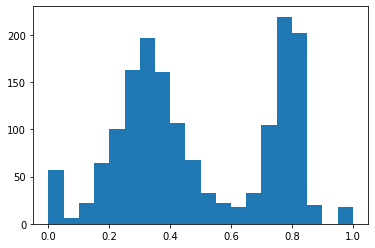

In [4103]:
plt.hist(table[table.columns[5]].ravel(),20,[0,1]); plt.show()


In [3679]:
np.argmin(table2[table2.columns[4]].ravel())

4

In [4104]:
np.where(table[table.columns[5]].ravel()>0.8)

(array([  10,   13,   17,   20,   21,   31,   33,   41,   42,   45,   46,
          48,   52,   56,   72,   84,   94,   97,   98,  101,  106,  110,
         129,  132,  139,  147,  151,  156,  170,  175,  182,  188,  190,
         191,  196,  200,  206,  208,  215,  223,  224,  226,  228,  230,
         235,  249,  271,  274,  278,  279,  301,  305,  311,  314,  333,
         353,  362,  373,  378,  379,  397,  399,  402,  408,  416,  440,
         443,  449,  452,  458,  462,  471,  475,  479,  482,  499,  505,
         510,  521,  524,  533,  537,  540,  547,  548,  554,  568,  569,
         588,  589,  591,  596,  603,  615,  618,  619,  623,  639,  684,
         685,  687,  695,  706,  711,  717,  726,  737,  764,  772,  779,
         787,  797,  799,  806,  817,  822,  824,  834,  835,  836,  849,
         850,  851,  855,  883,  895,  901,  919,  944,  945,  964,  973,
         988,  992,  996,  997,  998, 1006, 1008, 1010, 1016, 1017, 1024,
        1031, 1036, 1038, 1041, 1044, 

In [3844]:
np.where(table2[table2.columns[4]].ravel()>0.7)

(array([  50,   77,  117,  119,  155,  164,  177,  186,  233,  263,  295,
         298,  315,  317,  347,  426,  429,  460,  476,  482,  530,  548,
         564,  570,  579,  649,  661,  697,  704,  790,  795,  809,  811,
         813,  834,  853,  854,  860,  895,  896,  917,  926,  939,  977,
         985, 1084, 1095, 1116, 1123, 1147, 1165, 1184, 1199, 1211, 1219,
        1261, 1274, 1288, 1309, 1314, 1327, 1377, 1422, 1430, 1436, 1474,
        1514, 1515, 1544, 1555, 1573, 1595, 1606]),)

In [3843]:
table2.iloc[np.where(table2[table2.columns[4]].ravel()>0.7)]

,Individuo,Rep,Area,#C44A0F,#C87E39,#531705,#9F2609
0,I-062,5,968994.140625,0.000000,0.743333,0.000000,0.256667
0,I-465,10,93627.929688,0.217532,0.782468,0.000000,0.000000
0,I-448,4,968994.140625,0.000000,0.840841,0.000000,0.159159
0,I-292,3,160034.179688,0.000000,0.875000,0.125000,0.000000
0,I-477,4,116088.867188,0.000000,0.837150,0.000000,0.162850
...,...,...,...,...,...,...,...
0,I-453,2,968994.140625,0.000000,0.737024,0.262976,0.000000
0,I-344,7,173706.054688,0.000000,0.805466,0.000000,0.194534
0,I-179,8,109497.070312,0.000000,0.840000,0.000000,0.160000
0,I-299,5,258056.640625,0.000000,0.781971,0.218029,0.000000


In [3842]:
44+15+41

100

In [4141]:
i=13

In [4142]:
names[13]

'P-014_7.JPG'

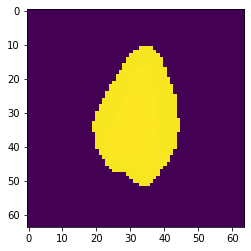

In [4143]:
img = cv2.cvtColor((ecoded_img[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
img = img.reshape((ecoded_img[i].shape[0] * ecoded_img[i].shape[1], 3))
#m=img.reshape(64*64*3)
k=5
kmeans=KMeans(n_clusters=k)
km = KMeans()
y_pred=kmeans.fit_predict(img)
clt=kmeans.fit(img)


Predi=y_pred.reshape(64,64)
im = Image.fromarray((Predi * 255).astype(np.uint8))
plt.imshow(im)
imgray = cv2.medianBlur((Predi * 255).astype(np.uint8),5,0)
plt.imshow(imgray)
contours, hierarchy  = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.cvtColor((data[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
res = cv2.bitwise_or(img,img,mask = imgray)
#plt.imshow(res)
res = res.reshape((ecoded_img[i].shape[0] * ecoded_img[i].shape[1], 3))

k=4
kmeans=KMeans(n_clusters=k)
km = KMeans()
y_pred=kmeans.fit_predict(res)
clt=kmeans.fit(res)
Predi=y_pred.reshape(64,64)
im = Image.fromarray((Predi * 255).astype(np.uint8))
imgray = cv2.medianBlur((Predi * 255).astype(np.uint8),5,0)

contours, hierarchy  = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area=cv2.contourArea(contours[0])
areatot=area*1000*1000/(64*64)
nombres=names[i].split(".")[0].split("_")
hist1 = centroid_histogram(clt)
bar1,percent1 = plot_colors(hist1, clt.cluster_centers_)
index=[]
for c in range(0,len(clt.cluster_centers_)):
    if (clt.cluster_centers_[c][0]<60 and  clt.cluster_centers_[c][1]<60 and  clt.cluster_centers_[c][0]<60):
        index.append(c)
(hist, _) = np.histogram(clt.labels_, bins = 5)
hist = hist.astype("float")
hist = np.delete(hist, index)
areas=hist/np.sum(hist)
arr=np.delete(clt.cluster_centers_,index,0)


In [4144]:
arr=arr.astype(int)
arr

array([[210,  58,  11],
       [245, 154,  77],
       [107,  77,  24]])

In [4145]:
hist1 = centroid_histogram(clt)
bar1,percent1 = plot_colors(hist1, clt.cluster_centers_)


In [4146]:
clt.cluster_centers_[1][0]

210.5820895522388

In [4147]:
index=[]
for c in range(0,len(clt.cluster_centers_)):
    if (clt.cluster_centers_[c][0]<60 and  clt.cluster_centers_[c][1]<60 and  clt.cluster_centers_[c][0]<60):
        index.append(c)
    

In [4148]:
index

[0]

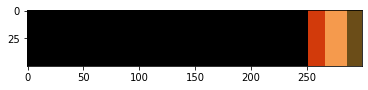

In [4149]:
plt.imshow(bar1)

In [4150]:
(hist, _) = np.histogram(clt.labels_, bins = 5)
hist = hist.astype("float")
#hist = hist[1:]
#hist /= hist.sum()
hist

array([3447.,  201.,    0.,  281.,  167.])

In [4151]:
hist = np.delete(hist, index)

In [4152]:
hist

array([201.,   0., 281., 167.])

In [4153]:
areas=hist/np.sum(hist)
#areas=hist/area

In [4154]:
areas

array([0.30970724, 0.        , 0.43297381, 0.25731895])

In [4155]:
np.sum(areas)

1.0

In [4156]:
arr=np.delete(clt.cluster_centers_,index,0)

In [4157]:
arr

array([[210.58208955,  58.19402985,  11.51243781],
       [245.76868327, 154.01423488,  77.09608541],
       [107.01796407,  77.58682635,  24.2754491 ]])

In [4158]:
if(arr[0][1]<60 and arr[0][2]<60):
    oscuro=areas[0]
    claro=areas[1]
else:
    oscuro=areas[1]
    claro=areas[0]

In [4159]:
clt.cluster_centers_

array([[9.46330142e-01, 2.60516391e-01, 5.16391065e-02],
       [2.10582090e+02, 5.81940299e+01, 1.15124378e+01],
       [2.45768683e+02, 1.54014235e+02, 7.70960854e+01],
       [1.07017964e+02, 7.75868263e+01, 2.42754491e+01]])

In [4160]:
np.unique(Predi)

array([0, 1, 2, 3], dtype=int32)

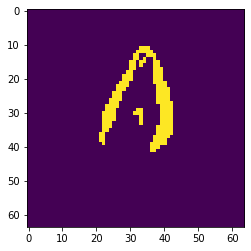

In [4163]:
mask = np.zeros(Predi.shape, dtype="uint8")
mask[Predi == 1] = 255
plt.imshow(mask)


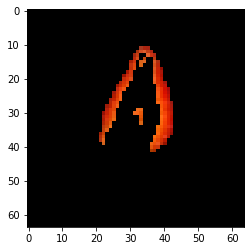

In [4164]:
img = cv2.cvtColor((data[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
res = cv2.bitwise_or(img,img,mask = mask)
plt.imshow(res)

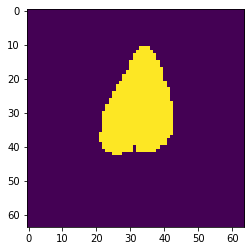

In [4165]:
mask = np.zeros(Predi.shape, dtype="uint8")
mask[Predi == 2] = 255
mask[Predi == 1] = 255
plt.imshow(mask)

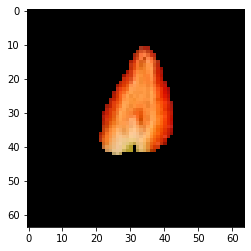

In [4166]:
img = cv2.cvtColor((data[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
res = cv2.bitwise_or(img,img,mask = mask)
plt.imshow(res) 

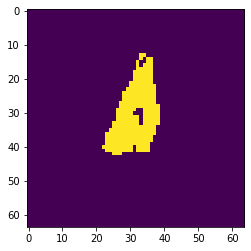

In [4172]:
mask = np.zeros(Predi.shape, dtype="uint8")
mask[Predi ==2] = 255
plt.imshow(mask)

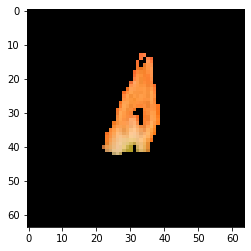

In [4173]:
img = cv2.cvtColor((data[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
res = cv2.bitwise_or(img,img,mask = mask)
plt.imshow(res)            

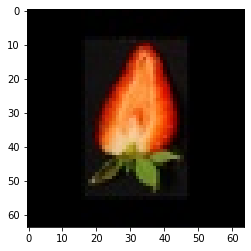

In [4171]:
plt.imshow(img)